In [6]:
import cv2
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import os
import cvxpy as cp

In [7]:
def save_image(img, save_path):
    """save image
    Args:
        img (np.ndarray or PIL.Image.Image): image to save
        save_path (str): save path
    """
    img = np.uint8(np.array(img))
    save_dir = os.path.dirname(save_path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not save_path.endswith('.jpg'):
        save_path = save_path + '.jpg'
    cv2.imwrite(save_path, img)

def getImgAsMatFromFile(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mat(img) 

def plotImg(imgMat):
    plt.imshow(imgMat, cmap=plt.cm.gray)
    plt.show()

## Roubst PCA
- 迭代算法
- 

In [11]:
def Cut(tau, X):
    '''
    Args: tau >= 0, X is a number or array
    Output: S = sgn(x)*max(|x|-tau,0)
    '''
    if len(X.shape)==1:
        #print(X.shape)
        X[(X<tau) & (X>-tau)] = 0
        X[X>=tau] = X[X>=tau] - tau
        X[X<=-tau] = X[X<=-tau] + tau
    elif len(X.shape)==2:
        m,n = X.shape
        X = np.array(np.reshape(X,m*n))
        #print(X.shape)
        X[(X<tau) & (X>-tau)] = 0
        X[X>=tau] = X[X>=tau] - tau
        X[X<=-tau] = X[X<=-tau] + tau      
        X = X.reshape([m,n])
    else:
        print('Err!')
    return X

def nuc_Cut(tau, X):
    X = np.mat(X)
    m, n = X.shape
    U, s, V=la.svd(X)
    s = Cut(tau, s)
    if m>=n:
        return U[:,:n]*np.diagflat(s)*V
    else:
        return U*np.diagflat(s)*(V[:m,:])
     
def RPCA(M, mu, lamb, itermax=1000, tol=1e-6):
    '''
    Args: matrix M; mu > 0; lamb > 0 (1/sqrt(n) recomended);
    Output: matrix L,S
        min ||L||_* + lamb ||S||_1
        ->
        min ||L||_* + lamb ||S||_1 + <Y,M-L-S> + mu/2 * ||M-L-S||_F^2
    '''
    m = M.shape[0]
    n = M.shape[1]

    L = cp.Variable((m,n))
    S = cp.Variable((m,n))
    Y = cp.Variable((m,n))

    # 目标函数
    obj = cp.Minimize(cp.norm(L,'nuc')+lamb*cp.norm(S,1))

    # 添加约束
    constraints = [L+S==M]

    # 定义增广拉格朗日函数
    aug_lagrangian = obj + cp.Minimize(mu/2 * cp.sum_squares(M-L-S))

    # 构建凸优化问题
    prob = cp.Problem(obj, constraints)

    prob.solve(solver=cp.SCS)
    # 提取结果
    L_opt = L.value
    S_opt = S.value

    return L_opt, S_opt

def RPCA_(M, mu, lamb, itermax=1000, tol=1e-6):
    '''
    Args: matrix M; mu > 0; lamb > 0 (1/sqrt(n) recomended);
    Output: matrix L,S
        min ||L||_* + lamb ||S||_1
        ->
        min ||L||_* + lamb ||S||_1 + <Y,M-L-S> + mu/2 * ||M-L-S||_F^2
    '''
    m,n = M.shape
    L = np.zeros([m,n])
    S = L#np.mat(M)
    Y = np.zeros([m,n])
    
    converged = False
    for i in range(itermax):
        L = nuc_Cut(mu, M-S-Y/mu)
        S = Cut(lamb*mu, M-L+Y/mu)
        Y = Y + mu*(M-L-S)

        if (cp.norm(M-L-S,'fro').value < tol*cp.norm(M,'fro').value)\
            & (cp.norm(Y,1).value<tol):
            break
        #if i%100==0:
        #    plotImg(L)
    
    return L,S

In [9]:
im = getImgAsMatFromFile('figures/mesh2.jpg')
im.shape

(206, 208)

In [ ]:
L, S = RPCA_(im, 1, 1/18, 2000, 1e-5)

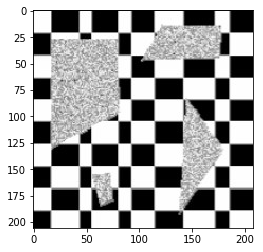

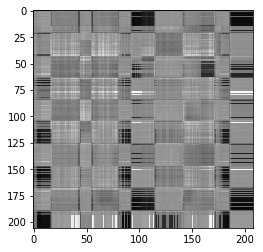

In [10]:
plotImg(im)
plotImg(L)

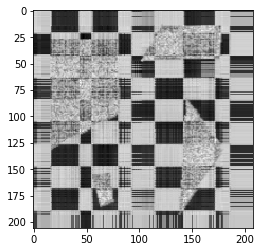

-1157021.6197710475

In [159]:
plotImg(S)
np.sum(S[S<0])

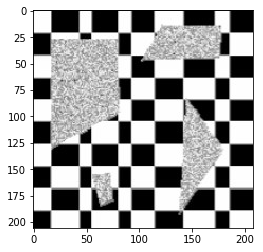

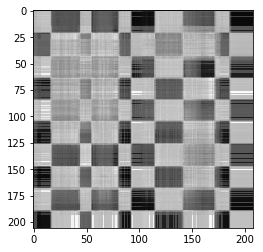

In [11]:
L, S = RPCA_(im, 1, 1/18, 1000, 1e-5)
plotImg(im)
plotImg(L)

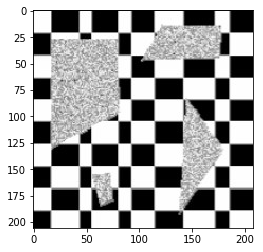

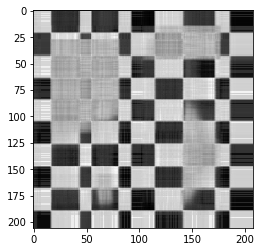

In [12]:
L, S = RPCA_(im, 0.5, 1/18, 1000, 1e-5)
plotImg(im)
plotImg(L)